In [42]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import plotly.express as px
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D

In [ ]:
# load the `train32.csv` file
path_to_data = "C:\\Users\\Marko\\Downloads\\archive\\"
train_df32 = pd.read_csv(path_to_data + "train64.csv")

def convert_indication_type(row):
    if row != "good":
        return "damaged"
    else:
        return "good"

def convert_indication_value(row):
    if row != 0:
        return 1
    else:
        return 0

train_df32["indication_type"] = train_df32["indication_type"].apply(convert_indication_type)
train_df32["indication_value"] = train_df32["indication_value"].apply(convert_indication_value)
train_df32.head()

,index,angle,indication_type,indication_value,split
0,48000,40,good,0,train
1,48001,60,good,0,train
2,48002,20,good,0,train
3,48003,40,good,0,train
4,48004,20,good,0,train


In [26]:
train_df32.indication_type.value_counts(normalize=True).round(2)

indication_type
damaged    0.83
good       0.17
Name: proportion, dtype: float64

In [ ]:
# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
  def __init__(self, hdf_path, ds_name="train"):
    self.path = hdf_path

    self.classes = []
    with h5py.File(self.path, 'r') as hf:
      for class_ in hf:
        self.classes.append(class_)

    self.name = ds_name

  # a generator to load the (img, class, angle)
  def generate_img_arr(self):
    for class_ in self.classes:
      with h5py.File(self.path, 'r') as hf:
        for angle in hf[class_]:
            for img in hf[class_][f"{angle}"]:
                yield img, class_, angle
  
  # utilize the generator to create new images and load it back to Storage
  def generate_train_dirs(self):
    path = f"/home/james/UVM/machine_learning/dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}
    
    random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")


    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          for j in range(4):
            img_path = f"{path}/{label}/{i}_aug{j}.jpeg"
            img = random_flip(tf.expand_dims(np.squeeze(img), axis=2)*255., training=True)
            plt.imsave(img_path, np.squeeze(img), cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          
        plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        metadata[img_path] = angle
    return metadata

  def generate_test_dirs(self):
    path = f"/home/james/UVM/machine_learning/dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          img_path = f"{path}/{label}/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle

    return metadata

  def to_storage(self):
    if self.name == "train":
      self.generate_train_dirs()

    elif self.name == "test":
      self.generate_test_dirs()

In [ ]:
# generate train data
train_gen = H5ToStorage(path_to_data + "matchingtDATASET_train_64.h5", "train")
train_dict = train_gen.to_storage()

FileExistsError: [Errno 17] File exists: '/home/james/UVM/machine_learning/dataset/train/good/'

In [ ]:

# generate test data
test_gen = H5ToStorage(path_to_data + "matchingtDATASET_test_64.h5", "test")
test_dict = test_gen.to_storage()

FileExistsError: [Errno 17] File exists: '/home/james/UVM/machine_learning/dataset/test/good/'

In [30]:

# train data & test data paths
test_dir = "dataset/test"
train_dir = "dataset/train"

In [ ]:
# create train data pipeline
IMG_SIZE = (64, 64)
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         validation_split=0.2,   # 20 % Validation
                                                         subset="training",
                                                         seed=123,
                                                         color_mode="grayscale",
                                                         label_mode="int",
                                                         batch_size=64)
# classes in train_data
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)


val_data = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    color_mode="grayscale",
    label_mode="int",
    batch_size=64
)

val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=32,
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 72000 files belonging to 2 classes.
Using 57600 files for training.
The class_names are as follows: ['damaged', 'good']
Found 72000 files belonging to 2 classes.
Using 14400 files for validation.
Found 36000 files belonging to 2 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

train_data = train_data.map(lambda x, y: (data_augmentation(x), y))

num_classes = len(class_names)

# Expand grayscale to 3 channels for ImageNet pretrained weights
inputs = Input(shape=(64, 64, 1))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(3, (3,3), padding="same")(x)
x = layers.Resizing(96, 96)(x)

# Load EfficientNet backbone
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3)
)

x = base_model(x)

base_model.trainable = False  # freeze pretrained weights

# Custom anomaly head
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [48]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [49]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_21 (Rescaling)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,207 (9.87 MB)

 Trainable params: 328,223 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [50]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5   # do only a few epochs while frozen
)

for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 163s 89ms/step - accuracy: 0.8336 - loss: 0.3913 - val_accuracy: 0.8426 - val_loss: 0.3746
Epoch 2/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 166s 92ms/step - accuracy: 0.8431 - loss: 0.3609 - val_accuracy: 0.8565 - val_loss: 0.3220
Epoch 3/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 165s 91ms/step - accuracy: 0.8483 - loss: 0.3432 - val_accuracy: 0.8612 - val_loss: 0.3068
Epoch 4/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 167s 93ms/step - accuracy: 0.8489 - loss: 0.3356 - val_accuracy: 0.8665 - val_loss: 0.2904
Epoch 5/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 166s 92ms/step - accuracy: 0.8516 - loss: 0.3333 - val_accuracy: 0.8633 - val_loss: 0.2866
Epoch 1/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 182s 99ms/step - accuracy: 0.8289 - loss: 0.8400 - val_accuracy: 0.8544 - val_loss: 0.3240
Epoch 2/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 175s 97ms/step - accuracy: 0.8440 - loss: 0.3524 - val_accuracy: 0.8620 - val_loss: 0.2994
Epoch 3/10
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 176s 98ms/step - accuracy: 0.853

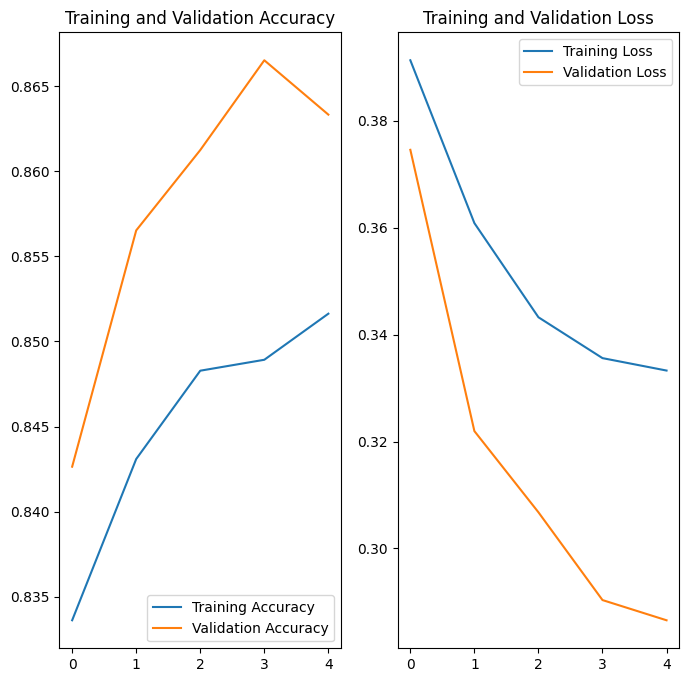

In [53]:
# Then plot with the correct number of epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
# y_true from test_data
y_true = np.concatenate([y.numpy() for _, y in test_data])

# predict
y_prob = model.predict(test_data).ravel()     
y_pred = (y_prob >= 0.5).astype(int)

print("F1 (binary):", f1_score(y_true, y_pred, average='binary'))
print(classification_report(y_true, y_pred, target_names=class_names))

2025-12-02 00:53:08.927065: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step
F1 (binary): 0.47089487402258906
              precision    recall  f1-score   support

     damaged       0.88      0.97      0.92     30000
        good       0.68      0.36      0.47      6000

    accuracy                           0.86     36000
   macro avg       0.78      0.66      0.70     36000
weighted avg       0.85      0.86      0.85     36000



In [ ]:

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
  ])




c:\Users\Marko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,841 (2.09 MB)

 Trainable params: 547,841 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=7
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/7


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 141s 102ms/step - accuracy: 0.8681 - loss: 0.2869 - val_accuracy: 0.9315 - val_loss: 0.1660
Epoch 2/7
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 79s 59ms/step - accuracy: 0.9550 - loss: 0.1200 - val_accuracy: 0.9773 - val_loss: 0.0653
Epoch 3/7
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 70s 52ms/step - accuracy: 0.9882 - loss: 0.0377 - val_accuracy: 0.9894 - val_loss: 0.0294
Epoch 4/7
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 86s 63ms/step - accuracy: 0.9963 - loss: 0.0129 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 5/7
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 66s 49ms/step - accuracy: 1.0000 - loss: 4.6208e-04 - val_accuracy: 1.0000 - val_loss: 1.5592e-04
Epoch 6/7
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 66s 49ms/step - accuracy: 1.0000 - loss: 8.5905e-05 - val_accuracy: 1.0000 - val_loss: 6.3946e-05
Epoch 7/7
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 91s 67ms/step - accuracy: 1.0000 - loss: 3.6069e-05 - val_accuracy: 1.0000 - val_loss: 2.8903e-05


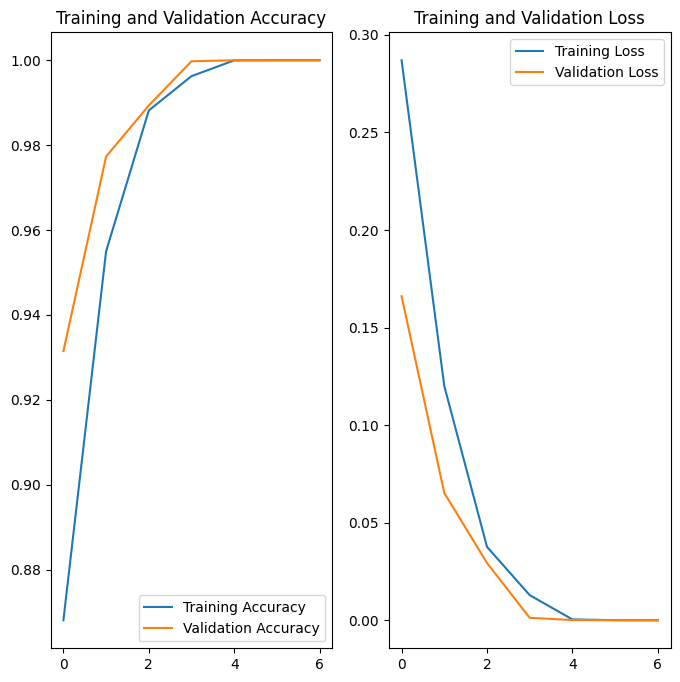

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# y_true from test_data
y_true = np.concatenate([y.numpy() for _, y in test_data])

# predict
y_prob = model.predict(test_data).ravel()     
y_pred = (y_prob >= 0.5).astype(int)

print("F1 (binary):", f1_score(y_true, y_pred, average='binary'))
print(classification_report(y_true, y_pred, target_names=class_names))

563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
F1 (binary): 0.7420494699646644
              precision    recall  f1-score   support

     damaged       0.97      0.92      0.94     30000
        good       0.66      0.84      0.74      6000

    accuracy                           0.90     36000
   macro avg       0.82      0.88      0.84     36000
weighted avg       0.92      0.90      0.91     36000

